<h1>In this notebook we create plots for unconditioned responses (p(x)). </h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuraldistributions.models import transforms
from neuraldistributions.datasets import static

from multiprocessing import Pool

import os
device = "cuda"

dataport not available, will only be able to load data locally


In [3]:
import numpy as np
import torch

from neuraldistributions.datasets import mouse_static_loaders, extract_data_key
from neuraldistributions.models import poisson, zig, flowfa, ziffa, flowfa_ident
from neuraldistributions.trainers import base_trainer
from neuraldistributions.utility import get_loglikelihood

from torch.distributions import LowRankMultivariateNormal

from tqdm import tqdm

In [4]:
random_seed=42
dataset_dir = "../project/data"
datasets = [
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6_dsampled.zip",
]
scan_id = [2, 1]
dataset_paths = [f"{dataset_dir}/{dataset}" for dataset in datasets]
areas = [["V1", "LM"]]
neurons_ns = [1000, 907]

In [5]:
dataset_index = 0
dataset_path = dataset_paths[dataset_index]
data_key = extract_data_key(dataset_path)
area = areas[dataset_index]
neurons_n = neurons_ns[dataset_index]

dataset_config = {
    "paths": [dataset_path],
    "seed": random_seed,
    "batch_size": 64,
    "area": area,
    "neurons_n": neurons_n,
    "normalize_images": True,
    "normalize_neurons": True,
    "return_more": True,
    "device": device,
    "shuffle_train": True,
    "return_real_responses": False
}

dataloaders = mouse_static_loaders(**dataset_config)

100%|██████████| 5994/5994 [00:00<00:00, 292711.04it/s]


In [6]:
model = torch.load("./models/FlowFA")
original = torch.load("./models/FlowFA-Original")
ziffa_model = torch.load("./models/ZIFFA-Original")

In [7]:
# get name of dataloader
index_name_of_dataloader = next(iter(dataloaders["train"]))

# get indices of repeated samples
indexes = np.arange(len(dataloaders["image_ids"][index_name_of_dataloader]["test"]))
u, inv = (np.unique(dataloaders["image_ids"][index_name_of_dataloader]["test"], return_inverse=True))

In [8]:
np.random.seed(random_seed)
random_neurons = np.random.choice(1000,9, replace=False)
random_images = np.random.choice(100,10, replace=False)
print(random_images)

[97 70 53 76 47 67 28 15 99 11]


521
737
740
660
411
678
626
513
859


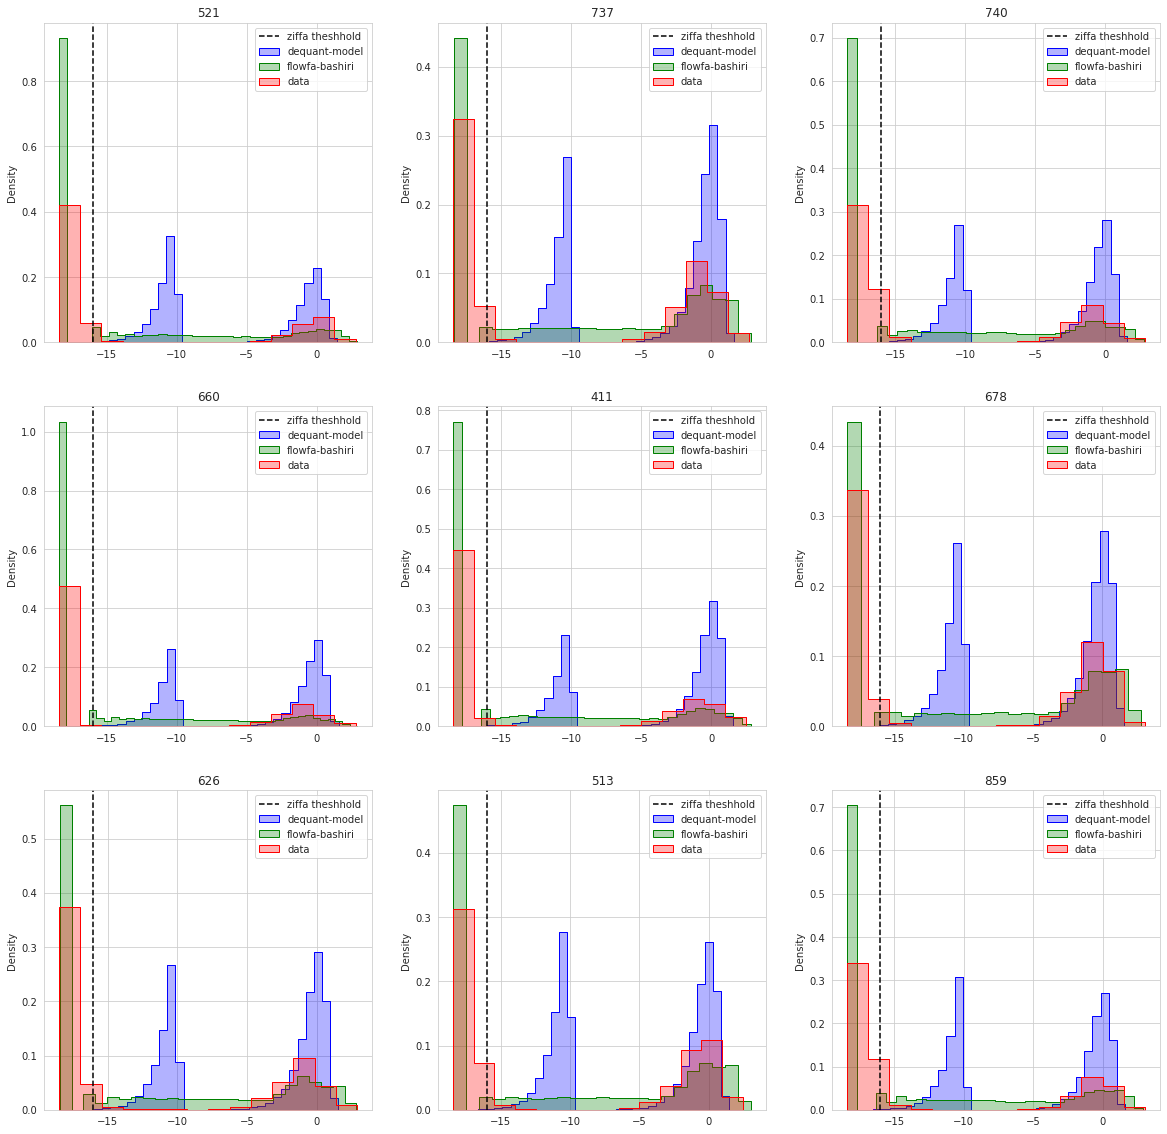

In [9]:
from neuralpredictors.training import LongCycler

# arrays for data hadnling
random_values_fa = []
random_values_orig = []
real_values = []
# go trough all the data
for batch_idx, (data_key, batch) in enumerate(LongCycler(dataloaders['train'])):
    
    # get mean create distrubutions for all our models
    mu_fa = model.forward(*batch, data_key=None)
    C, psi_diag = model.C_and_psi_diag
    normal_fa = LowRankMultivariateNormal(mu_fa, C.T, psi_diag)
    
    mu_orig = original.forward(*batch, data_key=None)
    C, psi_diag = original.C_and_psi_diag
    normal_orig = LowRankMultivariateNormal(mu_orig, C.T, psi_diag)
      
    # since our last batch does not has the same dimension than the others (less than 64 samples) we cant append them 
    if batch_idx != 69:
        
        # add the random samples
        random_values_fa.append(model.sample_transform.inv(normal_fa.sample([10]).to("cuda")).detach().cpu().numpy())
        random_values_orig.append(original.sample_transform.inv((normal_orig.sample([10]))).detach().cpu().numpy())
        
        # and the real data
        real_values.append(batch[1].detach().cpu().numpy())

# reshape data so we get all the data for the neurons
random_values_fa = torch.tensor(random_values_fa).reshape(-1,1000)

# for out dequant-model we have to put all negative values between 0 and e-10
random_values_fa = torch.where(random_values_fa < 0, torch.FloatTensor(random_values_fa.shape).uniform_(0, torch.exp(torch.tensor(-10.0))),random_values_fa+torch.exp(torch.tensor(-10.0)))
random_values_orig = torch.tensor(random_values_orig).reshape(-1,1000)
real_values = torch.tensor(real_values).reshape(-1,1000)


eps = 10**-8

fig, ax = plt.subplots(3,3, figsize=(20,20))

# plot all the data and save them in an image
for i, neuron in enumerate(random_neurons):
    print(neuron)
    sns.histplot(torch.log(random_values_fa[:,neuron].detach().cpu()+eps), ax=ax[i//3][i%3], stat="density", element="step", color="blue", alpha=0.3, label="dequant-model")
    sns.histplot(torch.log(random_values_orig[:,neuron].detach().cpu()+eps), ax=ax[i//3][i%3], stat="density", element="step", color="green", alpha=0.3, label="flowfa-bashiri")
    sns.histplot(torch.log(real_values[:,neuron].detach().cpu()+eps), ax=ax[i//3][i%3], stat="density", element="step", color="red", alpha=0.3,label="data" )
    ax[i//3][i%3].set_title(str(neuron))
    ax[i//3][i%3].axvline(x=np.log(1.1e-7), linestyle='dashed', label="ziffa theshhold", color="black")
    ax[i//3][i%3].legend()
    
plt.show()
fig.savefig("images/FlowFA-Fit-Test-Original-Data.pdf", format="pdf",dpi=300)